In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unrar x /content/drive/MyDrive/VOC2012.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/VOC2012.rar

Creating    VOC2012                                                   OK
Creating    VOC2012/Annotations                                       OK
Extracting  VOC2012/Annotations/2007_000032.xml                            0%  OK 
Extracting  VOC2012/Annotations/2007_000033.xml                            0%  OK 
Extracting  VOC2012/Annotations/2007_000039.xml                            0%  OK 
Extracting  VOC2012/Annotations/2007_000042.xml                            0%  OK 
Extracting  VOC2012/Annotations/2007_000061.xml                            0%  OK 
Extracting  VOC2012/Annotations/2007_000063.xml                            0%  OK 
Extracting  VOC2012/Annotations/2007_000068.xml                            0%  OK 
Extracting  VOC2012/Annotations/2007_000121.xml                            0%

In [3]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.datasets import ImageFolder

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets,models,transforms,utils
from torchvision.transforms import v2

import cv2
import os
from glob import glob
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import seaborn as sns

import albumentations as A
from albumentations.pytorch import ToTensorV2

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 39.6 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=c7240c9f0cf966f50b771cf0f30a52f7eb2a3914aaa553f737c3d5012c4bc8ed
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=8d571af1b70c901020d8a4e61edea4d8ca0ab56855e5183ba5f536ed120e3f3f
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorc

In [5]:
import segmentation_models_pytorch as smp

In [6]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [60]:
import os
import random
from sklearn.model_selection import train_test_split

image_files="/content/VOC2012/ImageSets/Segmentation/trainval.txt"

with open(image_files,"r+") as f:
  image_list=[line.strip() for line in f.readlines()]
train_images,val_images=train_test_split(image_list,test_size=0.2,random_state=42)

train_file="/content/VOC2012/ImageSets/Segmentation/train.txt"
val_file="/content/VOC2012/ImageSets/Segmentation/val.txt"

with open(train_file,"w") as f:
  for item in train_images:
    f.write(f"{item}\n")

with open(val_file,"w") as f:
  for item in val_images:
    f.write(f"{item}\n")

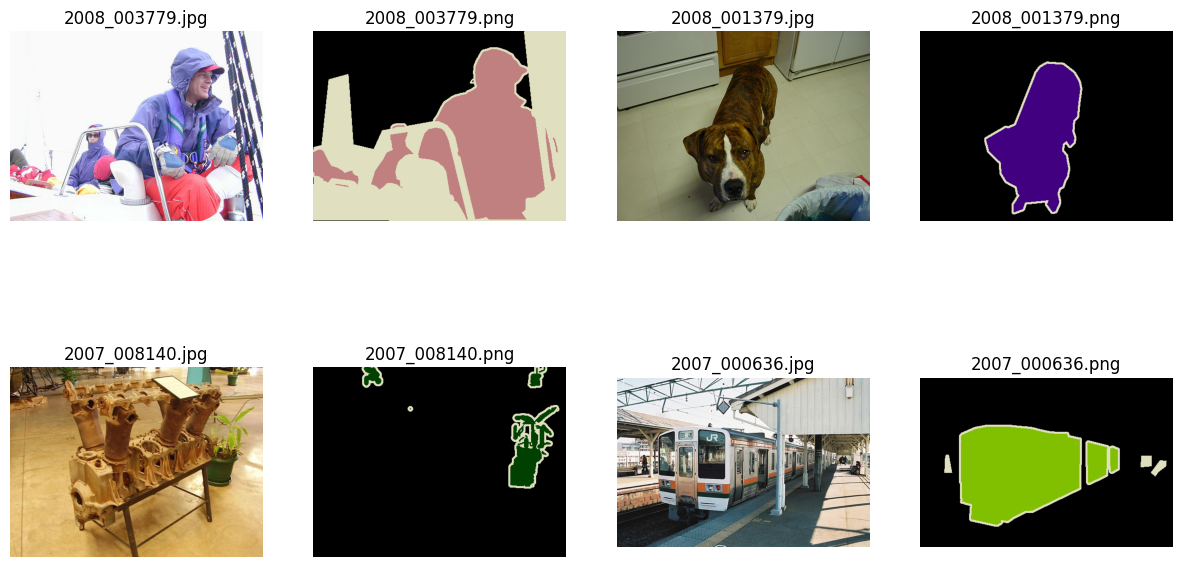

In [61]:
show_imgs=4
image_dir="/content/VOC2012/JPEGImages"
mask_dir="/content/VOC2012/SegmentationClass"
idx=np.random.choice(len(os.listdir(image_dir)),show_imgs,replace=False)
fig,axes=plt.subplots(show_imgs*2//4,4,figsize=(15,8))
axes=axes.flatten()
for i,ax in enumerate(axes):
  new_i=i//2
  if i%2==0:
    full_path=os.path.join(image_dir,sorted(os.listdir(image_dir))[idx[new_i]])

  else:
    full_path=os.path.join(mask_dir,sorted(os.listdir(mask_dir))[idx[new_i]])
  ax.imshow(plt.imread(full_path))
  basename=os.path.basename(full_path)
  ax.set_title(basename)
  ax.set_axis_off()

In [62]:
import os
import torch
from torchvision.datasets.vision import VisionDataset
from PIL import Image
from torchvision.transforms import transforms

train_transforms=A.Compose([
    A.Resize(224,224),
    A.RandomCrop(height=224,width=224,always_apply=True),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01,scale_limit=(-0.04,0.04),
                       rotate_limit=(-5,5),p=0.5),
])
test_transforms=A.Compose([
    A.Resize(224,224)
])



class PascalVOCDataset(VisionDataset):
  def __init__(self,root,image_set='train',transforms=None):
    super().__init__(root,transforms=transforms)
    self.image_set=image_set
    base_dir=os.path.join(root,"VOC2012")

    self.image_dir=os.path.join(base_dir,"JPEGImages")
    self.mask_dir=os.path.join(base_dir,"SegmentationClass")

    split_file=os.path.join(base_dir,"ImageSets","Segmentation",f"{image_set}.txt")
    with open(split_file,"r") as f:
      self.image_list=[line.strip() for line in f.readlines()]

    self.pre_normalize=v2.Compose([
        v2.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]),
    ])
    self.transforms=transforms
    self.resize=[224,224]
    self.class_size=220


  def __len__(self):
    return len(self.image_list)

  def __getitem__(self,idx):
    img_name=self.image_list[idx]
    img_path=os.path.join(self.image_dir,img_name+".jpg")
    mask_path=os.path.join(self.mask_dir,img_name+".png")


    img=cv2.cvtColor(cv2.imread(img_path),cv2.COLOR_BGR2RGB)
    mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)


    mask[mask > self.class_size - 1] = 0


    aug=self.transforms(image=img,mask=mask)
    img,mask=aug['image'],aug['mask']
    img=img/255
    img=self.pre_normalize(img)
    img=torch.tensor(img,dtype=torch.float32).permute(2,0,1)
    target=torch.tensor(mask,dtype=torch.long)
    sample={'x':img,'y':target}
    return sample


In [63]:
device=torch.device('cuda' if torch.cuda.is_available() else "cpu")
root_dir="/content/"
train_dataset = PascalVOCDataset(root=root_dir, image_set='train', transforms=train_transforms)
val_dataset = PascalVOCDataset(root=root_dir, image_set='val', transforms=test_transforms)

BATCH_SIZE=2
train_loader=DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=False)


In [64]:
print(len(train_dataset))
print(len(val_dataset))

800
200


### Create Model

In [65]:
class_size=220
model=smp.Unet(encoder_name="efficientnet-b0",
               encoder_weights="imagenet",
               in_channels=3,
               classes=class_size,
               )

In [76]:
def train(dataloader,model,loss_fn,optimizer,lr_scheduler,device):
  size=len(dataloader.dataset)
  num_batches=len(dataloader)
  model.train()
  epoch_loss=0
  epoch_iou_score=0
  for batch_i,batch in enumerate(dataloader):
    x,y=batch['x'].to(device),batch['y'].to(device)
    optimizer.zero_grad()
    pred=model(x)
    loss=loss_fn(pred,y)

    loss.backward()
    optimizer.step()

    epoch_loss+=loss.item()
    y=y.round().long()
    pred=torch.argmax(pred,dim=1)
    tp,fp,fn,tn=smp.metrics.get_stats(pred,y,mode="multiclass",num_classes=class_size)
    iou_score=smp.metrics.iou_score(tp,fp,fn,tn,reduction="micro").item()
    epoch_iou_score+=iou_score

  return epoch_loss/num_batches,epoch_iou_score/num_batches

def test(dataloader,model,loss_fn,device):
  size=len(dataloader.dataset)
  num_batches=len(dataloader)
  model.eval()
  epoch_loss=0
  epoch_iou_score=0
  with torch.no_grad():
    for batch_i,batch in enumerate(dataloader):
      x,y=batch['x'].to(device),batch['y'].to(device)
      pred=model(x)
      # print(pred)

      loss=loss_fn(pred,y)
      epoch_loss+=loss.item()
      y=y.round().long()
      pred=torch.argmax(pred,dim=1)


      tp,fp,fn,tn=smp.metrics.get_stats(pred,y,mode="multiclass",num_classes=class_size)
      iou_score=smp.metrics.iou_score(tp,fp,fn,tn,reduction="micro").item()

      epoch_iou_score+=iou_score
  return epoch_loss/num_batches,epoch_iou_score/num_batches

In [77]:
from torch.optim.lr_scheduler import CosineAnnealingLR
device=torch.device('cuda' if torch.cuda.is_available() else "cpu")
EPOCHS=50
logs={
    'train_loss':[],'val_loss':[],
    'train_iou_score':[],'val_iou_score':[],
}
if not os.path.exists('/content/VOC2012/checkpoints'):
  os.makedirs("/content/VOC2012/checkpoints")

loss_fn=torch.nn.CrossEntropyLoss()

learning_rate=0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
step_lr_scheduler = CosineAnnealingLR(optimizer, T_max=10)
# step_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2,threshold=1e-5, verbose=True)
patience=10
counter=0
best_loss=np.inf

model.to(device)
for epoch in tqdm(range(EPOCHS)):
  train_loss,train_iou_score=train(train_loader,model,loss_fn,optimizer,step_lr_scheduler,device)
  val_loss,val_iou_score=test(val_loader,model,loss_fn,device)
  logs['train_loss'].append(train_loss)
  logs['val_loss'].append(val_loss)
  logs['train_iou_score'].append(train_iou_score)
  logs['val_iou_score'].append(val_iou_score)

  print(f'EPOCH: {str(epoch+1).zfill(3)} \
  train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f} \
  train_iou_score: {train_iou_score:.3f}, val_iou_score: {val_iou_score:.3f} \
  lr: {optimizer.param_groups[0]["lr"]}')
  print(f'Before lr step: val_loss: {val_loss}')
  step_lr_scheduler.step()
  print(f'After lr step: lr: {optimizer.param_groups[0]["lr"]}')
  torch.save(model.state_dict(),"/content/VOC2012/checkpoints/last.pth")

  if val_loss<best_loss:
    counter=0

    best_loss=val_loss
    torch.save(model.state_dict(),"/content/VOC2012/checkpoints/best.pth")
  else:
    counter+=1

  if counter>=patience:
    print("Early stopping")
    break

  2%|▏         | 1/50 [00:39<32:37, 39.96s/it]

EPOCH: 001   train_loss: 0.9099, val_loss: 0.7785   train_iou_score: 0.638, val_iou_score: 0.682   lr: 0.0001
Before lr step: val_loss: 0.7785308091342449
After lr step: lr: 9.755282581475769e-05


  4%|▍         | 2/50 [01:20<32:12, 40.27s/it]

EPOCH: 002   train_loss: 0.8944, val_loss: 0.7694   train_iou_score: 0.642, val_iou_score: 0.683   lr: 9.755282581475769e-05
Before lr step: val_loss: 0.7694329130649566
After lr step: lr: 9.045084971874737e-05


  6%|▌         | 3/50 [02:00<31:29, 40.20s/it]

EPOCH: 003   train_loss: 0.8782, val_loss: 0.7641   train_iou_score: 0.642, val_iou_score: 0.685   lr: 9.045084971874737e-05
Before lr step: val_loss: 0.764116520434618
After lr step: lr: 7.938926261462366e-05


  8%|▊         | 4/50 [02:40<30:52, 40.27s/it]

EPOCH: 004   train_loss: 0.8705, val_loss: 0.7639   train_iou_score: 0.645, val_iou_score: 0.686   lr: 7.938926261462366e-05
Before lr step: val_loss: 0.7638813227415084
After lr step: lr: 6.545084971874737e-05


 10%|█         | 5/50 [03:21<30:10, 40.23s/it]

EPOCH: 005   train_loss: 0.8597, val_loss: 0.7625   train_iou_score: 0.650, val_iou_score: 0.686   lr: 6.545084971874737e-05
Before lr step: val_loss: 0.762493726760149
After lr step: lr: 4.9999999999999996e-05


 12%|█▏        | 6/50 [04:00<29:25, 40.11s/it]

EPOCH: 006   train_loss: 0.8576, val_loss: 0.7634   train_iou_score: 0.648, val_iou_score: 0.688   lr: 4.9999999999999996e-05
Before lr step: val_loss: 0.7634281913936138
After lr step: lr: 3.454915028125263e-05


 14%|█▍        | 7/50 [04:40<28:40, 40.01s/it]

EPOCH: 007   train_loss: 0.8389, val_loss: 0.7552   train_iou_score: 0.653, val_iou_score: 0.687   lr: 3.454915028125263e-05
Before lr step: val_loss: 0.7552368405461312
After lr step: lr: 2.0610737385376345e-05


 16%|█▌        | 8/50 [05:20<27:59, 39.99s/it]

EPOCH: 008   train_loss: 0.8321, val_loss: 0.7535   train_iou_score: 0.654, val_iou_score: 0.684   lr: 2.0610737385376345e-05
Before lr step: val_loss: 0.753484107106924
After lr step: lr: 9.549150281252631e-06


 18%|█▊        | 9/50 [06:00<27:15, 39.90s/it]

EPOCH: 009   train_loss: 0.8220, val_loss: 0.7540   train_iou_score: 0.655, val_iou_score: 0.686   lr: 9.549150281252631e-06
Before lr step: val_loss: 0.7540236300230027
After lr step: lr: 2.447174185242323e-06


 20%|██        | 10/50 [06:40<26:35, 39.88s/it]

EPOCH: 010   train_loss: 0.8234, val_loss: 0.7513   train_iou_score: 0.653, val_iou_score: 0.687   lr: 2.447174185242323e-06
Before lr step: val_loss: 0.75128671169281
After lr step: lr: 0.0


 22%|██▏       | 11/50 [07:20<25:54, 39.86s/it]

EPOCH: 011   train_loss: 0.8242, val_loss: 0.7550   train_iou_score: 0.655, val_iou_score: 0.688   lr: 0.0
Before lr step: val_loss: 0.7550262789428234
After lr step: lr: 2.4471741852423237e-06


 24%|██▍       | 12/50 [08:00<25:18, 39.95s/it]

EPOCH: 012   train_loss: 0.8166, val_loss: 0.7540   train_iou_score: 0.657, val_iou_score: 0.686   lr: 2.4471741852423237e-06
Before lr step: val_loss: 0.7539993369579315
After lr step: lr: 9.549150281252667e-06


 26%|██▌       | 13/50 [08:40<24:38, 39.97s/it]

EPOCH: 013   train_loss: 0.8289, val_loss: 0.7503   train_iou_score: 0.654, val_iou_score: 0.687   lr: 9.549150281252667e-06
Before lr step: val_loss: 0.7502678427100181
After lr step: lr: 2.0610737385376434e-05


 28%|██▊       | 14/50 [09:20<23:59, 40.00s/it]

EPOCH: 014   train_loss: 0.8210, val_loss: 0.7538   train_iou_score: 0.658, val_iou_score: 0.687   lr: 2.0610737385376434e-05
Before lr step: val_loss: 0.7538371074199677
After lr step: lr: 3.4549150281252785e-05


 30%|███       | 15/50 [10:00<23:17, 39.94s/it]

EPOCH: 015   train_loss: 0.8260, val_loss: 0.7555   train_iou_score: 0.654, val_iou_score: 0.684   lr: 3.4549150281252785e-05
Before lr step: val_loss: 0.7555150134861469
After lr step: lr: 5.0000000000000226e-05


 32%|███▏      | 16/50 [10:40<22:38, 39.96s/it]

EPOCH: 016   train_loss: 0.8203, val_loss: 0.7537   train_iou_score: 0.657, val_iou_score: 0.684   lr: 5.0000000000000226e-05
Before lr step: val_loss: 0.7537266808748245
After lr step: lr: 6.545084971874767e-05


 34%|███▍      | 17/50 [11:20<21:58, 39.95s/it]

EPOCH: 017   train_loss: 0.8202, val_loss: 0.7515   train_iou_score: 0.660, val_iou_score: 0.686   lr: 6.545084971874767e-05
Before lr step: val_loss: 0.751497248262167
After lr step: lr: 7.938926261462401e-05


 36%|███▌      | 18/50 [12:00<21:22, 40.06s/it]

EPOCH: 018   train_loss: 0.8141, val_loss: 0.7531   train_iou_score: 0.660, val_iou_score: 0.685   lr: 7.938926261462401e-05
Before lr step: val_loss: 0.7531004849076272
After lr step: lr: 9.045084971874779e-05


 38%|███▊      | 19/50 [12:40<20:43, 40.10s/it]

EPOCH: 019   train_loss: 0.8150, val_loss: 0.7736   train_iou_score: 0.660, val_iou_score: 0.686   lr: 9.045084971874779e-05
Before lr step: val_loss: 0.7735598641633987
After lr step: lr: 9.755282581475812e-05


 40%|████      | 20/50 [13:20<20:04, 40.16s/it]

EPOCH: 020   train_loss: 0.8042, val_loss: 0.7736   train_iou_score: 0.662, val_iou_score: 0.685   lr: 9.755282581475812e-05
Before lr step: val_loss: 0.7735772469639778
After lr step: lr: 0.00010000000000000044


 42%|████▏     | 21/50 [14:01<19:24, 40.16s/it]

EPOCH: 021   train_loss: 0.8041, val_loss: 0.7722   train_iou_score: 0.662, val_iou_score: 0.684   lr: 0.00010000000000000044
Before lr step: val_loss: 0.7721592183411121
After lr step: lr: 9.75528258147581e-05


 44%|████▍     | 22/50 [14:41<18:44, 40.15s/it]

EPOCH: 022   train_loss: 0.7888, val_loss: 0.7513   train_iou_score: 0.664, val_iou_score: 0.680   lr: 9.75528258147581e-05
Before lr step: val_loss: 0.7512897354364395
After lr step: lr: 9.04508497187478e-05


 44%|████▍     | 22/50 [15:21<19:32, 41.89s/it]

EPOCH: 023   train_loss: 0.7730, val_loss: 0.7520   train_iou_score: 0.669, val_iou_score: 0.686   lr: 9.04508497187478e-05
Before lr step: val_loss: 0.7520409579575061
After lr step: lr: 7.938926261462401e-05
Early stopping


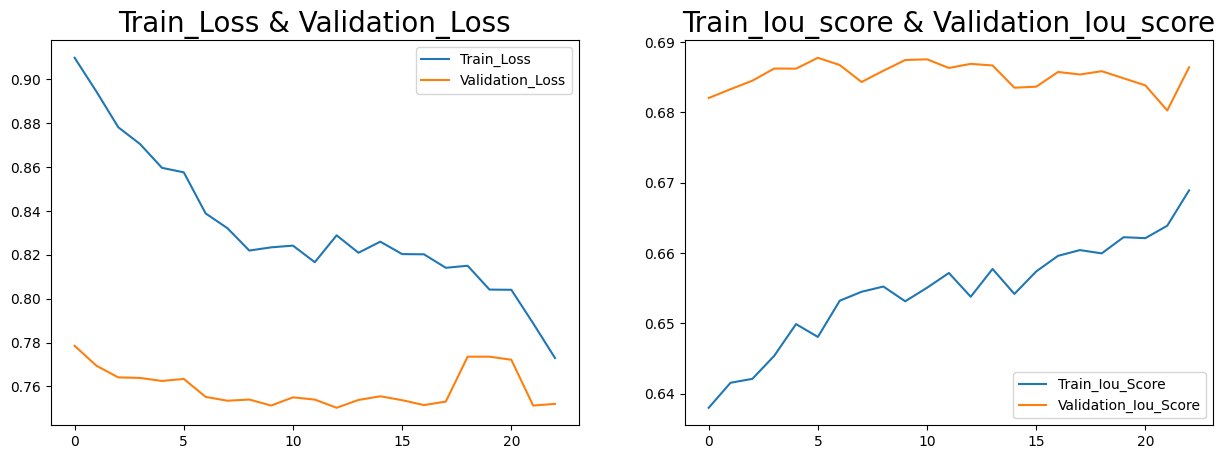

In [78]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(logs['train_loss'],label='Train_Loss')
plt.plot(logs['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(logs['train_iou_score'],label='Train_Iou_Score')
plt.plot(logs['val_iou_score'],label='Validation_Iou_Score')
plt.title('Train_Iou_score & Validation_Iou_score',fontsize=20)
plt.legend()

In [79]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, root,image_set, transforms_=None):

        # We'll use transforms for data augmentation and converting PIL images to torch tensors.
        self.transforms_ = transforms_
        self.image_set=image_set
        base_dir=os.path.join(root,"VOC2012")

        self.image_dir=os.path.join(base_dir,"JPEGImages")
        self.mask_dir=os.path.join(base_dir,"SegmentationClass")

        split_file=os.path.join(base_dir,"ImageSets","Segmentation",f"{image_set}.txt")
        with open(split_file,"r") as f:
          self.image_list=[line.strip() for line in f.readlines()]

        self.pre_normalize = v2.Compose([
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.resize = [224, 224]
        self.class_size = 220

    def __len__(self):
        return len(self.image_dir)

    def __getitem__(self, index):
        img_name=self.image_list[idx]
        img_path=os.path.join(self.image_dir,img_name+".jpg")
        mask_path=os.path.join(self.mask_dir,img_name+".png")


        img=cv2.cvtColor(cv2.imread(img_path),cv2.COLOR_BGR2RGB)
        mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)

        mask[mask>self.class_size-1]=0
        aug=self.transforms_(image=img,mask=mask)
        img,mask=aug['image'],aug['mask']
        img_view = np.copy(img)
        mask_view = np.copy(mask)
        img = img/255
        img = self.pre_normalize(img)
        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
        target = torch.tensor(mask, dtype=torch.long)
        sample = {'x': img, 'y': target, 'img_view':img_view, 'mask_view':mask_view}
        return sample


test_dataset = TestDataset(root=root_dir, image_set='val' , transforms_=test_transforms)


<ipython-input-81-15b58e3edd10>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/VOC2012/checkpoints/best.pth"))


Prediction shape: torch.Size([1, 220, 224, 224])
Predicted mask shape: torch.Size([224, 224])


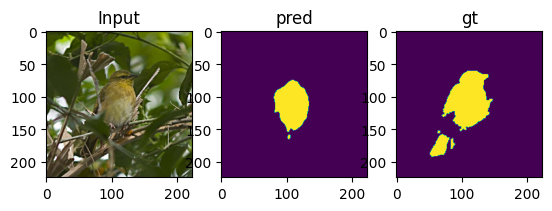

Prediction shape: torch.Size([1, 220, 224, 224])
Predicted mask shape: torch.Size([224, 224])


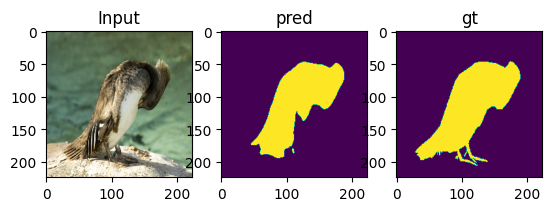

Prediction shape: torch.Size([1, 220, 224, 224])
Predicted mask shape: torch.Size([224, 224])


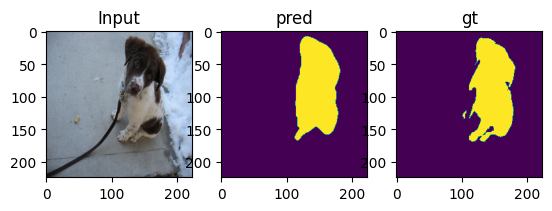

Prediction shape: torch.Size([1, 220, 224, 224])
Predicted mask shape: torch.Size([224, 224])


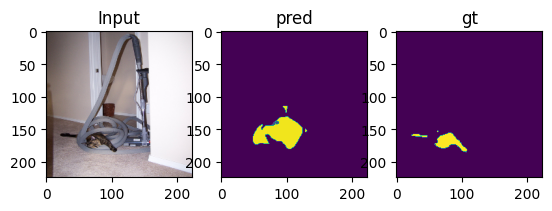

In [81]:
model.load_state_dict(torch.load("/content/VOC2012/checkpoints/best.pth"))
model.to(device)
show_imgs = 4
random_list = np.random.choice(len(test_dataset), show_imgs, replace=False)

for i in range(show_imgs):
    idx = random_list[i]
    sample = test_dataset[idx]
    pred = model(sample['x'].to('cuda', dtype=torch.float32).unsqueeze(0))
    print(f'Prediction shape: {pred.shape}')

    pred = torch.argmax(pred,dim=1).squeeze(0)

    print(f'Predicted mask shape: {pred.shape}')
    pred = pred.data.cpu().numpy()
    # print(f'pred_2.shape: {pred.shape}')
    pred_view = Image.fromarray(np.uint8(pred), 'L')

    img_view = sample['img_view']
    img_view = Image.fromarray(img_view, 'RGB')
    mask_view = sample['mask_view']

    mask_view = Image.fromarray(mask_view, 'L')

    f, axarr = plt.subplots(1, 3)
    axarr[0].imshow(img_view)
    axarr[0].set_title('Input')
    axarr[1].imshow(pred_view)
    axarr[1].set_title('pred')
    axarr[2].imshow(mask_view)
    axarr[2].set_title('gt')
    plt.show()